In [1]:
import sacc
import numpy as np
import pyccl as ccl
import rosatX as rx
import pyatomdb
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import pickle

rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})
rc("text", usetex=True)

## Loading the data

In [2]:
# Load response matrices
rmf = fits.open("data/pspcb_gain2_256.rmf")
arf = fits.open("data/pspcb_gain2_256.arf")

cls_cov = sacc.Sacc.load_fits("data/cls_cov_y3.fits")
ROSAT, DESY3wl__3, cov = cls_cov.get_ell_cl(
    "cl_0e", "ROSAT", "DESY3wl__3", return_cov=True)
err = np.sqrt(np.diagonal(cov))

## Initialising defaults and tracers

In [3]:
# Set up cosmology and halo profiles
cosmo = ccl.CosmologyVanillaLCDM()
mdef = ccl.halos.MassDef200c
cM = ccl.halos.ConcentrationDuffy08(mass_def=mdef)

dmat = ccl.halos.HaloProfileNFW(mass_def=mdef, concentration=cM)
nM = ccl.halos.MassFuncTinker08(mass_def=mdef)
bM = ccl.halos.HaloBiasTinker10(mass_def=mdef)
hmc = ccl.halos.HMCalculator(mass_def=mdef,
                             mass_function=nM,
                             halo_bias=bM,
                             log10M_max=15.0,
                             log10M_min=10,
                             nM=32)

# Redshift and number density
zs = cls_cov.tracers["DESY3wl__3"].z
nz = cls_cov.tracers["DESY3wl__3"].nz

# X-ray tracer
tx = rx.XrayTracer(cosmo)

# Weak lensing tracer
ts = ccl.WeakLensingTracer(cosmo, dndz=(zs, nz))

## Calculating the X-ray Spectrum

In [4]:
# Setting for X-ray parameters
kTmin = 0.02
kTmax = 50.0
nkT = 32
zmax = 4.0
nz = 16
emin = 0.5
emax = 2.0

Zmetal = 0.3
Zs = np.ones(31)
Zs[3:] = Zmetal

# Initialize ROSAT spectrum session
rosat_spectrum = pyatomdb.spectrum.CIESession()
rosat_spectrum.set_response(rmf, arf)
rosat_spectrum.set_abund(np.arange(31, dtype=int), Zs)

# Load or calculate integrated X-ray spectra
if os.path.isfile("data/Jtot.pck"):
    with open("data/Jtot.pck", "rb") as f:
        J_tot = pickle.load(f)
else:
    J_tot = rosat_spectrum.return_integrated_spectrum_interp(
        kTmin, kTmax, nkT, zmax, nz, emin, emax)
    with open("data/Jtot.pck", "wb") as f:
        pickle.dump(J_tot, f)

# Load or calculate continuum-only X-ray spectra
if os.path.isfile("data/Jcont.pck"):
    with open("data/Jcont.pck", "rb") as f:
        J_cont = pickle.load(f)
else:
    J_cont = rosat_spectrum.return_integrated_spectrum_interp(
        kTmin, kTmax, nkT, zmax, nz, emin, emax, dolines=False, dopseudo=False)
    with open("data/Jcont.pck", "wb") as f:
        pickle.dump(J_cont, f)

## Calculating the X-ray profiles

In [5]:
a = 1.0
x = np.geomspace(0.001, 5, 128)
M = 1e14
r200 = mdef.get_radius(cosmo, M, a) / a
r = r200 * x

# Battaglia
density_bg = rx.HaloProfileDensityBattaglia(
                mass_def=mdef, kind="n_total")
pressure_bg = rx.HaloProfilePressureBattaglia(
                mass_def=mdef, kind="n_total", kind_P="n_total")

x_bg = rx.HaloProfileXray(mass_def=mdef,
                          J=J_tot,
                          density=density_bg,
                          pressure=pressure_bg,
                          fourier_approx=False,
                          with_clumping=True)

# NFW
density_nfw = rx.HaloProfileDensityNFW(
                mass_def=mdef, kind="n_total", concentration=cM)
pressure_nfw = rx.HaloProfilePressureNFW(
                mass_def=mdef, kind="n_total", concentration=cM)

x_nfw = rx.HaloProfileXray(mass_def=mdef,
                           J=J_tot,
                           density=density_nfw,
                           pressure=pressure_nfw,
                           fourier_approx=False,
                           plaw_fourier=-2.7)

# Hydrostatic Equilibirum
density_he = rx.HaloProfileDensityHE(
                mass_def=mdef, kind="n_total", concentration=cM)
pressure_he = rx.HaloProfilePressureHE(
                mass_def=mdef, kind="n_total", concentration=cM)
# Full
x_he = rx.HaloProfileXray(mass_def=mdef,
                          J=J_tot,
                          density=density_he,
                          pressure=pressure_he,
                          fourier_approx=False,
                          with_clumping=True)
# Continuum only
x_he_cont = rx.HaloProfileXray(mass_def=mdef,
                          J=J_cont,
                          density=density_he,
                          pressure=pressure_he,
                          fourier_approx=False,
                          with_clumping=True)

## Calculating the $P(k)$s and $C_\ell$s

In [6]:
k_arr = np.geomspace(1e-4, 1e2, 256)
a_arr = np.linspace(0.3, 1, 8)
ls = np.unique(np.geomspace(2, 3100, 128).astype(int)).astype(float)


pk_bg = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat,
                               prof2=x_bg, lk_arr=np.log(k_arr), a_arr=a_arr)
cl = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_bg)
cl_bg = rx.profiles.cl_smoothed(cl, ls)


pk_nfw = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat,
                                prof2=x_nfw, lk_arr=np.log(k_arr), a_arr=a_arr)
cl = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_nfw)
cl_nfw = rx.profiles.cl_smoothed(cl, ls)


pk_he = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat,
                               prof2=x_he, lk_arr=np.log(k_arr), a_arr=a_arr)
cl = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_he)
cl_he = rx.profiles.cl_smoothed(cl, ls)

pk_he_cont = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat,
                                    prof2=x_he_cont, lk_arr=np.log(k_arr), a_arr=a_arr)
cl = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_he_cont)
cl_he_cont = rx.profiles.cl_smoothed(cl, ls)

## Plotting the $C_\ell$s

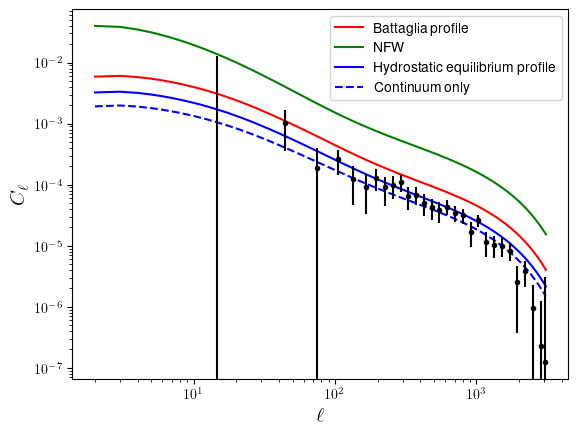

In [7]:
plt.plot(ls, cl_bg, "r", label="Battaglia profile")
plt.plot(ls, cl_nfw, "g", label="NFW")
plt.plot(ls, cl_he, "b", label="Hydrostatic equilibrium profile")
plt.plot(ls, cl_he_cont, "b", linestyle="--", label="Continuum only")
plt.errorbar(ROSAT, DESY3wl__3, yerr=err, fmt="k.")
plt.loglog()
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_\ell$", fontsize=15)
plt.legend()

plt.savefig('Plots/Cls_profiles_comparison.pdf');